In [1]:
import sys
sys.path.append('/home/599/dbi599/unseen/unseen')
import os
import glob

import matplotlib.pyplot as plt
import geopandas as gp
import regionmask
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from shapely.geometry import Polygon
#from dask.distributed import Client, LocalCluster

import fileio
import time_utils
import spatial_selection
import array_handling

In [2]:
#cluster = LocalCluster()
#client = Client(cluster)

In [3]:
#client

In [2]:
# command line parameters
abares_shapefile = 'abares.zip'
agcd_file = '/g/data/ia39/agcd/post-processed/data/agcd_v2_precip_total_cafe-grid_monthly_1900-2020.zarr.zip'
agcd_config = '/home/599/dbi599/unseen/config/dataset_agcd_monthly.yml'

In [3]:
cafe_config = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
cafe_files = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-*/atmos_isobaric_daily.zarr.zip')
cafe_files.sort()
cafe_files

['/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19810501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19811101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19820501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19821101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19830501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19831101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19840501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19841101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19850501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19851101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19860501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19861101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/d

In [8]:
cafe_files[38:40]

['/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20000501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20001101/atmos_isobaric_daily.zarr.zip']

In [9]:
# Required parameters
assert os.path.isfile(abares_shapefile), "Must provide the ABARES shapefile (papermill option -p abares_shapefile [filepath])"
assert os.path.isfile(agcd_file), "Must provide the AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(agcd_config), "Must provide the AGCD configuration file (papermill option -p agcd_config [filepath])"

# Define regions 

## ABARES regions

The Australian Bureau of Agricultural and Resource Economics and Sciences (ABARES) defines a set of [Australian broadacre zones and regions](https://apps.agriculture.gov.au/agsurf/regions.html). The relevant shapefiles can be downloaded from:  
https://www.agriculture.gov.au/abares/research-topics/surveys/farm-survey-data

Here's an image showing how vegetation maps onto the wheat/sheep region:  
https://www.agriculture.gov.au/sites/default/files/images/ag-snapshot-2021-2-01.jpg

In [10]:
abares = gp.read_file(abares_shapefile)
abares

,aagis,class,name,zone,geometry
0,111,111,NSW Far West,Pastoral,"POLYGON ((146.37539 -28.99878, 146.94501 -28.9..."
1,121,121,NSW North West Slopes and Plains,Wheat Sheep,"POLYGON ((150.29716 -28.54252, 150.29783 -28.5..."
2,122,122,NSW Central West,Wheat Sheep,"POLYGON ((149.02819 -30.60890, 149.05246 -30.6..."
3,123,123,NSW Riverina,Wheat Sheep,"POLYGON ((145.34428 -32.68249, 145.33056 -32.7..."
4,131,131,NSW Tablelands (Northern Central and Southern),High Rainfall,"POLYGON ((152.51672 -28.25466, 152.51610 -28.2..."
5,132,132,NSW Coastal,High Rainfall,"MULTIPOLYGON (((150.05118 -37.26355, 150.05099..."
6,221,221,VIC Mallee,Wheat Sheep,"POLYGON ((140.96768 -33.98983, 140.96827 -33.9..."
7,222,222,VIC Wimmera,Wheat Sheep,"POLYGON ((141.99493 -35.64500, 141.99495 -35.6..."
8,223,223,VIC Central North,Wheat Sheep,"POLYGON ((145.53410 -35.80522, 145.53390 -35.8..."
9,231,231,VIC Southern and Eastern Victoria,High Rainfall,"MULTIPOLYGON (((146.29518 -39.15886, 146.29331..."


## Custom regions

Break the wheat-sheep region into a south-west, south-east and north-east region and have those regions follow the boundaries of the associated CAFE grid boxes. 

In [11]:
sw = Polygon([(115, -28.314607),
              (115, -32.359551),
              (117.5, -32.359551),
              (117.5, -34.382022),
              (125, -34.382022),
              (125, -32.359551),
              (120, -32.359551),
              (120, -30.337079),
              (117.5, -30.337079),
              (117.5, -28.314607),
             ])

se = Polygon([(140, -34.382022),
              (140, -32.359551),
              (135, -32.359551),
              (135, -34.382022),
              (140, -34.382022),
              (140, -36.404494),              
              (147.5, -36.404494),
              (147.5, -32.359551),
              (145, -32.359551),
              (145, -34.382022),
              (140, -34.382022),
             ])

ne = Polygon([(147.5, -22.247191),
              (147.5, -34.382022),
              (150, -34.382022),
              (150, -30.337079),
              (152.5, -30.337079),
              (152.5, -26.292135),
              (150, -26.292135),
              (150, -22.247191),
             ])

custom_wheat_sheep = gp.GeoDataFrame({'region': ['south-west', 'south-east', 'north-east'],
                                      'geometry': gp.GeoSeries([sw, se, ne])})
custom_wheat_sheep

,region,geometry
0,south-west,"POLYGON ((115.00000 -28.31461, 115.00000 -32.3..."
1,south-east,"POLYGON ((140.00000 -34.38202, 140.00000 -32.3..."
2,north-east,"POLYGON ((147.50000 -22.24719, 147.50000 -34.3..."


In [8]:
custom_wheat_sheep.to_file('wheat_sheep.shp')

## Australia region

Dissolve the internal borders of the ABARES regions to create an Australia shapefile.

In [9]:
#aus = abares.dissolve()
#aus = gp.GeoDataFrame({'country': ['Australia'],
#                       'geometry': aus.geometry})
#aus.to_file('australia.shp')

## Plot regions

... including grid lines corresponding to the CAFE grid.

In [12]:
lat_bounds = np.array([-90.      , -88.988764, -86.966292, -84.94382 , -82.921348, -80.898876,
       -78.876404, -76.853933, -74.831461, -72.808989, -70.786517, -68.764045,
       -66.741573, -64.719101, -62.696629, -60.674157, -58.651685, -56.629213,
       -54.606742, -52.58427 , -50.561798, -48.539326, -46.516854, -44.494382,
       -42.47191 , -40.449438, -38.426966, -36.404494, -34.382022, -32.359551,
       -30.337079, -28.314607, -26.292135, -24.269663, -22.247191, -20.224719,
       -18.202247, -16.179775, -14.157303, -12.134831, -10.11236 ,  -8.089888,
        -6.067416,  -4.044944,  -2.022472,   0.      ,   2.022472,   4.044944,
         6.067416,   8.089888,  10.11236 ,  12.134831,  14.157303,  16.179775,
        18.202247,  20.224719,  22.247191,  24.269663,  26.292135,  28.314607,
        30.337079,  32.359551,  34.382022,  36.404494,  38.426966,  40.449438,
        42.47191 ,  44.494382,  46.516854,  48.539326,  50.561798,  52.58427 ,
        54.606742,  56.629213,  58.651685,  60.674157,  62.696629,  64.719101,
        66.741573,  68.764045,  70.786517,  72.808989,  74.831461,  76.853933,
        78.876404,  80.898876,  82.921348,  84.94382 ,  86.966292,  88.988764,
        90.      ])

In [13]:
lon_bounds = np.array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,
        25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,
        50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,
        75. ,  77.5,  80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
       100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5,
       125. , 127.5, 130. , 132.5, 135. , 137.5, 140. , 142.5, 145. , 147.5,
       150. , 152.5, 155. , 157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5,
       175. , 177.5, 180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
       200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5,
       325. , 327.5, 330. , 332.5, 335. , 337.5, 340. , 342.5, 345. , 347.5,
       350. , 352.5, 355. , 357.5, 360. ])

In [14]:
abares_wheat_sheep = abares[abares.zone == 'Wheat Sheep']

In [15]:
abares_wheat_sheep['region'] = ['north-east',
                                'north-east',
                                'south-east',
                                'south-east',
                                'south-east',
                                'south-east',
                                'north-east',
                                'north-east',
                                'south-east',
                                'south-east',
                                'south-west',
                                'south-west']

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [16]:
abares_wheat_sheep

,aagis,class,name,zone,geometry,region
1,121,121,NSW North West Slopes and Plains,Wheat Sheep,"POLYGON ((150.29716 -28.54252, 150.29783 -28.5...",north-east
2,122,122,NSW Central West,Wheat Sheep,"POLYGON ((149.02819 -30.60890, 149.05246 -30.6...",north-east
3,123,123,NSW Riverina,Wheat Sheep,"POLYGON ((145.34428 -32.68249, 145.33056 -32.7...",south-east
6,221,221,VIC Mallee,Wheat Sheep,"POLYGON ((140.96768 -33.98983, 140.96827 -33.9...",south-east
7,222,222,VIC Wimmera,Wheat Sheep,"POLYGON ((141.99493 -35.64500, 141.99495 -35.6...",south-east
8,223,223,VIC Central North,Wheat Sheep,"POLYGON ((145.53410 -35.80522, 145.53390 -35.8...",south-east
14,321,321,QLD Eastern Darling Downs,Wheat Sheep,"POLYGON ((151.24101 -26.52643, 151.24312 -26.5...",north-east
15,322,322,QLD Western Downs and Central Highlands,Wheat Sheep,"POLYGON ((146.92819 -21.51004, 146.93123 -21.5...",north-east
18,421,421,SA Eyre Peninsula,Wheat Sheep,"MULTIPOLYGON (((136.11366 -35.33342, 136.11484...",south-east
19,422,422,SA Murray Lands and Yorke Peninsula,Wheat Sheep,"MULTIPOLYGON (((136.84612 -35.37357, 136.84525...",south-east


In [17]:
se = abares_wheat_sheep[abares_wheat_sheep.region == 'south-east']
ne = abares_wheat_sheep[abares_wheat_sheep.region == 'north-east']
sw = abares_wheat_sheep[abares_wheat_sheep.region == 'south-west']

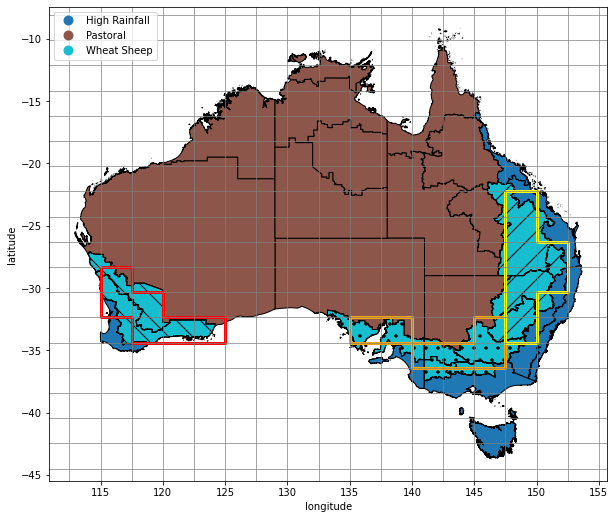

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

abares.plot(ax=ax,
            column='zone',
            legend=True,
            edgecolor='black',
            legend_kwds={'loc': 'upper left'} )

se.plot(ax=ax,
        column='region',
        edgecolor='black',
        facecolor='none',
        hatch='.',
        )

ne.plot(ax=ax,
        column='region',
        edgecolor='black',
        facecolor='none',
        hatch='/',
        )

sw.plot(ax=ax,
        column='region',
        edgecolor='black',
        facecolor='none',
        hatch='\\',
        )

custom_wheat_sheep.plot(ax=ax,
                        column='region',
                        edgecolor=['red', 'orange', 'yellow'],
                        facecolor='none',
                        linewidth=3)

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

for lat in lat_bounds:
    if (lat > ymin) and (lat < ymax):
        ax.axhline(lat, color='0.5', linewidth=0.7)

for lon in lon_bounds:
    if (lon > xmin) and (lon < xmax):
        ax.axvline(lon, color='0.5', linewidth=0.7)

plt.ylabel('latitude')
plt.xlabel('longitude')
plt.savefig('/g/data/xv83/dbi599/ag/figures/ag_regions.png',
            bbox_inches='tight', facecolor='white', dpi=400)

# Regional rainfall

Rainfall at each grid point was considered to determine the boundary between the north-east and south-east regions and to consider how well the CAFE model represents observed rainfall.

In [18]:
agcd_ds = fileio.open_file(agcd_file,
                           variables=['pr'],
                           metadata_file=agcd_config,
                           sel={'time': slice('1990-01-01', '2019-12-31')},
                           units={'pr': 'mm/day'})
agcd_ds

<xarray.Dataset>
Dimensions:  (lat: 17, lon: 17, time: 360)
Coordinates:
  * lat      (lat) float64 -43.48 -41.46 -39.44 -37.42 ... -15.17 -13.15 -11.12
  * lon      (lon) float64 113.8 116.2 118.8 121.2 ... 146.2 148.8 151.2 153.8
  * time     (time) object 1990-01-16 00:00:00 ... 2019-12-16 00:00:00
Data variables:
    pr       (time, lat, lon) float64 dask.array<chunksize=(20, 17, 17), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                       http://www.bom.gov.au/climate/
    uuid:                      43596dc1-c56e-42a2-ba87-4e3b726a6e60

In [19]:
agcd_clim_ds = agcd_ds.groupby('time.month').mean('time')

In [20]:
cafe_ds = fileio.open_mfforecast(cafe_files[38:40],
                                 variables=['pr'],
                                 time_freq='M',
                                 time_agg='mean',
                                 input_freq='D',
                                 complete_time_agg_periods=True,
                                 metadata_file=cafe_config,
                                 units={'pr': 'mm/day'},
                                 spatial_coords=[-44, -11, 113, 154]
                                )

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

In [21]:
cafe_ds.compute()

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 2, lat: 17, lead_time: 120, lon: 17)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lat        (lat) float64 -43.48 -41.46 -39.44 ... -15.17 -13.15 -11.12
  * lon        (lon) float64 113.8 116.2 118.8 121.2 ... 146.2 148.8 151.2 153.8
  * init_date  (init_date) object 2000-05-31 00:00:00 2000-11-30 00:00:00
    time       (lead_time, init_date) object 2000-05-31 00:00:00 ... 2010-10-...
Data variables:
    pr         (init_date, lead_time, ensemble, lat, lon) float32 3.487 ... 8...
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

In [22]:
cafe_ds_reindexed = array_handling.reindex_forecast(cafe_ds)

In [23]:
cafe_ds_reindexed

,Array,Chunk
Bytes,40.64 MiB,108.38 kiB
Shape,"(2, 192, 96, 17, 17)","(1, 1, 96, 17, 17)"
Count,7648 Tasks,384 Chunks
Type,float32,numpy.ndarray


In [21]:
#selection = time_utils.select_time_period(cafe_ds_reindexed, ['1990-01-01', '2019-12-31'])

In [ ]:
#selection.compute()

In [24]:
cafe_clim_ds = cafe_ds_reindexed.groupby('time.month').mean(dim=['ensemble', 'init_date', 'time'], skipna=True)

In [25]:
cafe_clim_ds.compute()

<xarray.Dataset>
Dimensions:  (lat: 17, lon: 17, month: 12)
Coordinates:
  * lat      (lat) float64 -43.48 -41.46 -39.44 -37.42 ... -15.17 -13.15 -11.12
  * lon      (lon) float64 113.8 116.2 118.8 121.2 ... 146.2 148.8 151.2 153.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    pr       (month, lat, lon) float32 1.645 1.552 1.502 ... 7.054 8.831 10.07

## Grid point plots

In [26]:
def plot_monthly_clim(agcd_clim_da, cafe_clim_da, lat, lon):
    """Plot monthly climatology"""
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    cafe_sel = cafe_clim_da.sel(lat=lat, lon=lon, method='nearest')
    cafe_sel.plot(label='CAFE')
    
    agcd_sel = agcd_clim_da.sel(lat=lat, lon=lon, method='nearest')
    agcd_sel.plot(label='AGCD')
    
    plt.legend()
    plt.show()

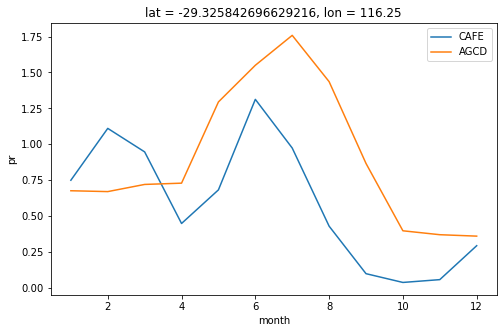

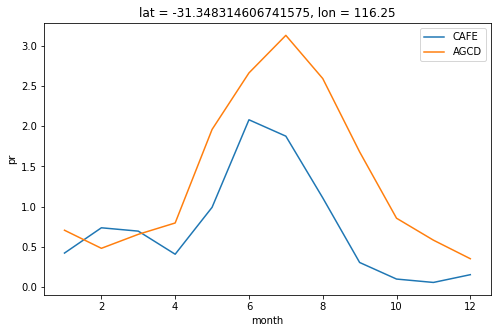

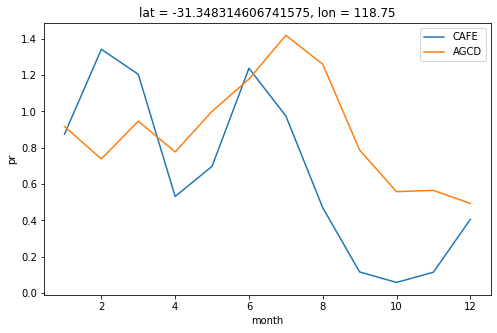

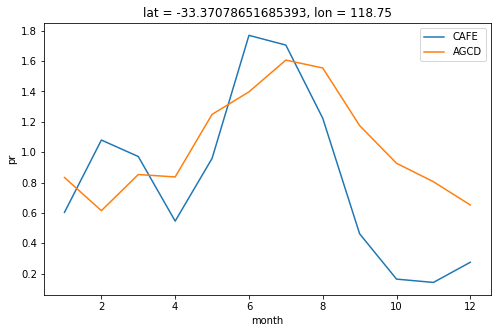

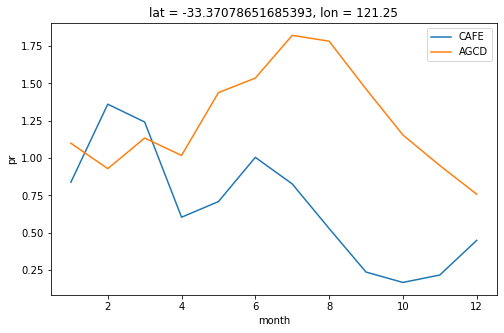

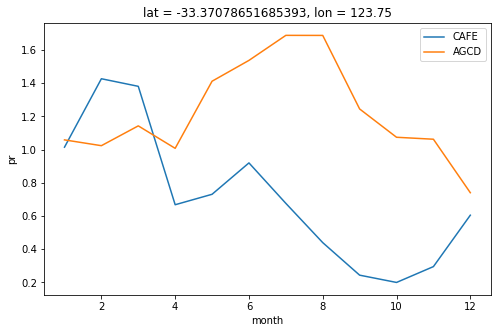

In [27]:
wa_points = [[-29, 116],
             [-31, 116],
             [-31, 118],
             [-33, 118],
             [-33, 121],
             [-33, 124]
            ]

for lat, lon in wa_points:
    plot_monthly_clim(agcd_clim_ds['pr'], cafe_clim_ds['pr'], lat, lon)

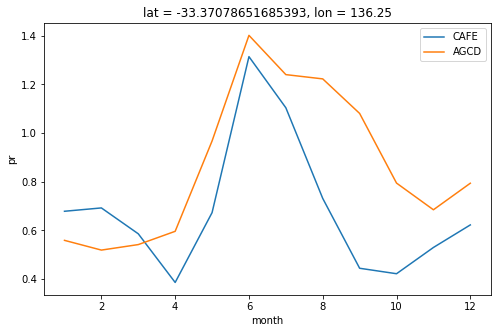

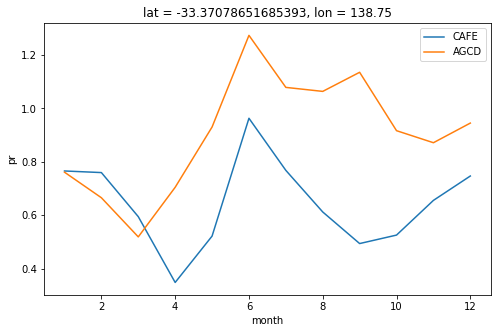

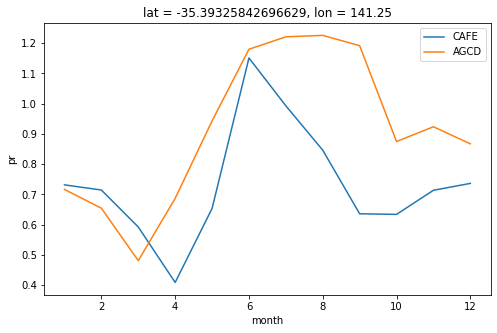

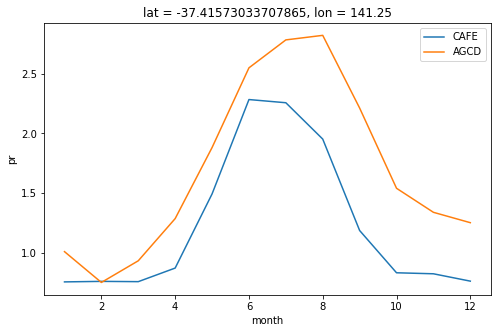

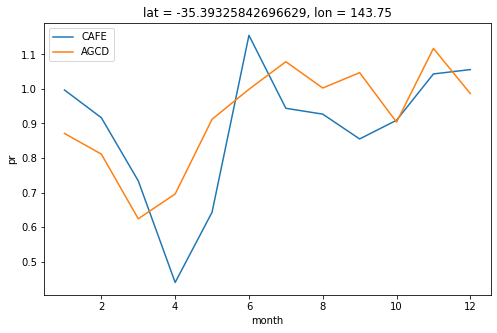

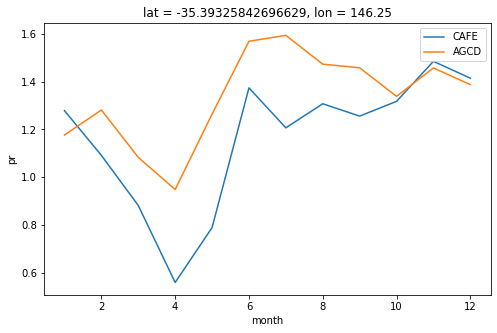

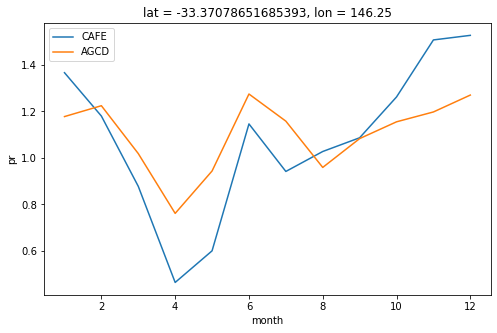

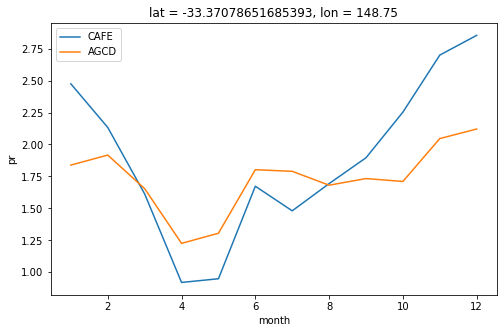

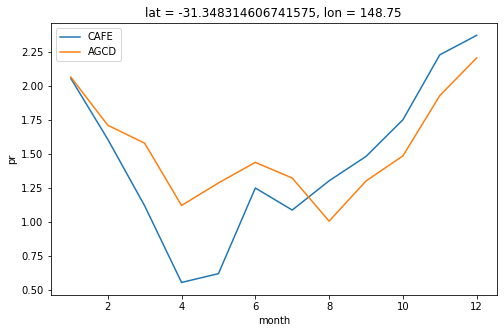

In [28]:
se_points = [[-33, 136],
             [-33, 138],
             [-35, 141],
             [-37, 141],
             [-35, 144],
             [-35, 146],
             [-33, 146],
             [-33, 148],
             [-31, 148]
            ]

for lat, lon in se_points:
    plot_monthly_clim(agcd_clim_ds['pr'], cafe_clim_ds['pr'], lat, lon)

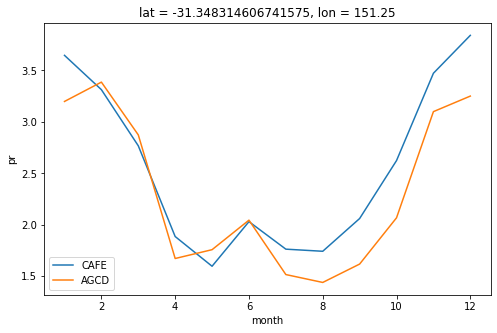

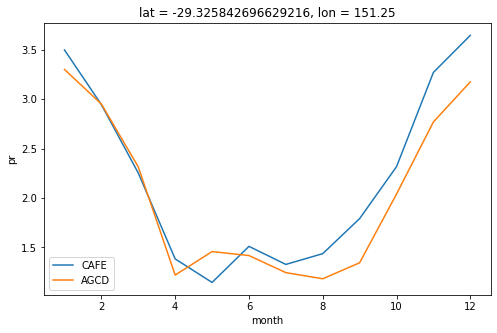

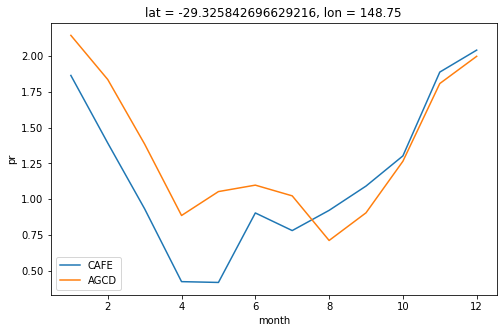

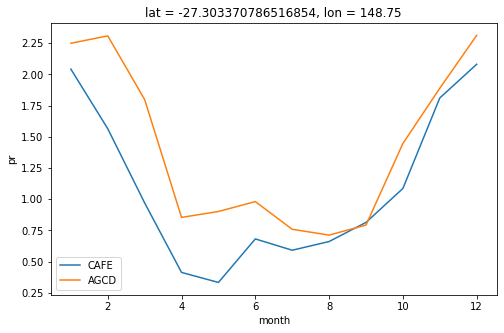

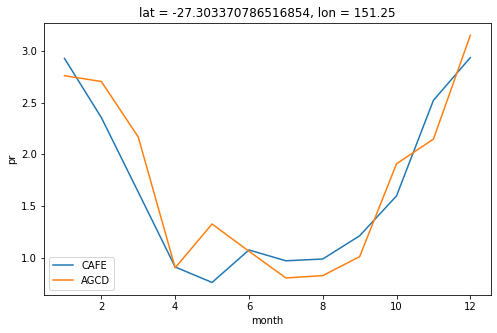

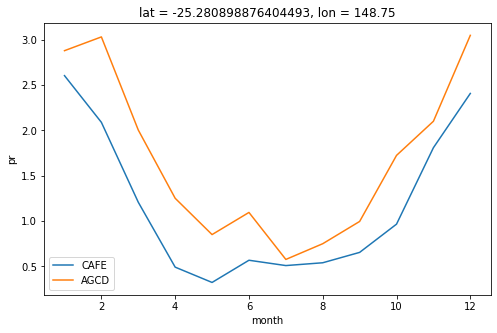

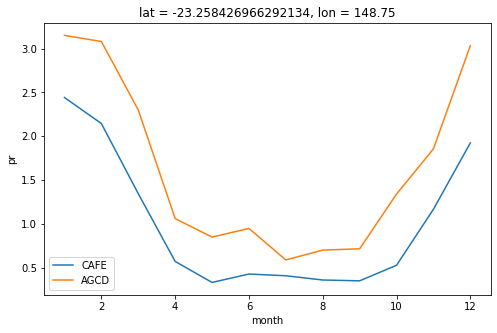

In [29]:
ne_points = [[-31, 151],
             [-29, 151],
             [-29, 148],
             [-27, 148],
             [-27, 151],
             [-25, 148],
             [-23, 148],
            ]

for lat, lon in ne_points:
    plot_monthly_clim(agcd_clim_ds['pr'], cafe_clim_ds['pr'], lat, lon)

#### South-West (SW) region

-29.325843, 116.25  Winter peak  
-31.348315, 116.25  Winter peak  
-31.348315, 118.75  Winter peak (AWAP), dual peak (CAFE)  
-33.370787, 118.75  Winter peak  
-33.370787, 121.25  Winter peak (AWAP), late summer peak (CAFE)  
-33.370787, 123.75  Winter peak (AWAP), late summer peak (CAFE)  

#### South-East (SE) region

-33.370787, 136.25  Winter peak  
-33.370787, 138.75  Winter peak, almost dual peak (CAFE)  
-35.393258, 141.25  Winter peak  
-37.41573,  141.25  Winter peak  
-35.393258, 143.75  Winter into spring peak  
-35.393258, 146.25  Winter into spring peak  
-33.370787, 146.25  Flat or mild dual peak (summer and winter; AWAP), summer peak (CAFE)  
  
-33.370787, 148.75  Flat or mild dual peak (summer and winter; AWAP), summer peak (CAFE)  
-31.348315, 148.75  Summer peak  

#### North-East (NE) region

-31.348315, 151.25  Summer peak  
-29.325843, 151.25  Summer peak  
-29.325843, 148.75  Summer peak  
-27.303371, 148.75  Summer peak  
-27.303371, 151.25  Summer peak  
-25.280899, 148.75  Summer peak  
-23.258427, 148.75  Summer peak  

## Regional means

In [30]:
agcd_regional_means = spatial_selection.select_shapefile_regions(agcd_clim_ds, 'wheat_sheep.shp', agg='mean', header='region')

In [32]:
cafe_regional_means = spatial_selection.select_shapefile_regions(cafe_clim_ds, 'wheat_sheep.shp', agg='mean', header='region')

In [40]:
def plot_regional_mean(agcd_da, cafe_da, region):
    """Plot regional mean"""
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    cafe_sel = cafe_da.sel(region=region)
    cafe_sel.plot(label='CAFE')
    
    agcd_sel = agcd_da.sel(region=region)
    agcd_sel.plot(label='AGCD')
    
    plt.ylabel('average monthly rainfall total (mm)')
    plt.title(region)
    plt.legend()
    plt.show()

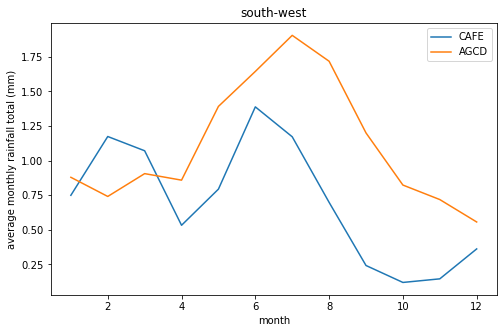

In [41]:
plot_regional_mean(agcd_regional_means['pr'],
                   cafe_regional_means['pr'],
                   'south-west')

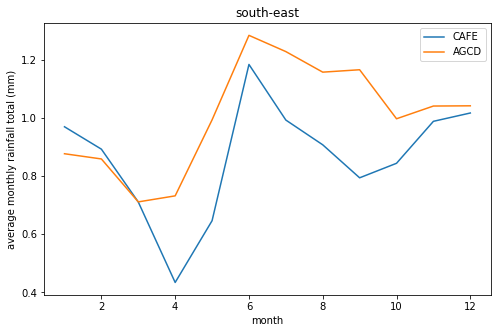

In [42]:
plot_regional_mean(agcd_regional_means['pr'],
                   cafe_regional_means['pr'],
                   'south-east')

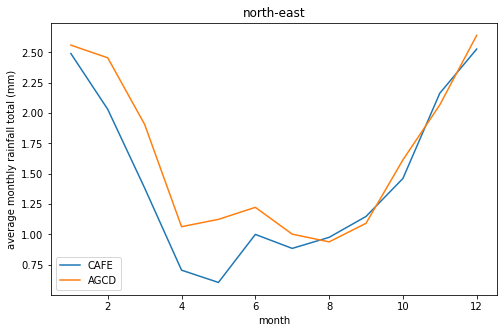

In [43]:
plot_regional_mean(agcd_regional_means['pr'],
                   cafe_regional_means['pr'],
                   'north-east')